In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 4.0 MB/s 


In [ ]:
from  matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import cv2
from PIL import Image, ImageFilter
from kornia.filters import gaussian_blur2d, spatial_gradient, filter2d
import torchvision.transforms as tf
import torch
import glob
import tqdm
from scipy import ndimage
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.transform import warp
from skimage.transform import rescale, resize, downscale_local_mean



In [ ]:
'''
python by:  youngjung uh, Clova ML, Naver
contact:    youngjung.uh@navercorp.com
date:       17 Dec 2018

-------------------------------------------------------------------
----- below comment came from the original (flowToColor.m) --------
-------------------------------------------------------------------
flowToColor(flow, maxFlow) flowToColor color codes flow field, normalize
based on specified value,

flowToColor(flow) flowToColor color codes flow field, normalize
based on maximum flow present otherwise

According to the c++ source code of Daniel Scharstein
Contact: schar@middlebury.edu

Author: Deqing Sun, Department of Computer Science, Brown University
Contact: dqsun@cs.brown.edu
$Date: 2007-10-31 18:33:30 (Wed, 31 Oct 2006) $

Copyright 2007, Deqing Sun.

                        All Rights Reserved

Permission to use, copy, modify, and distribute this software and its
documentation for any purpose other than its incorporation into a
commercial product is hereby granted without fee, provided that the
above copyright notice appear in all copies and that both that
copyright notice and this permission notice appear in supporting
documentation, and that the name of the author and Brown University not be used in
advertising or publicity pertaining to distribution of the software
without specific, written prior permission.

THE AUTHOR AND BROWN UNIVERSITY DISCLAIM ALL WARRANTIES WITH REGARD TO THIS SOFTWARE,
INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY
PARTICULAR PURPOSE.  IN NO EVENT SHALL THE AUTHOR OR BROWN UNIVERSITY BE LIABLE FOR
ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES
WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN
ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF
OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.
'''

import numpy as np

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


# flowToColor(np.zeros((224,224,2)))

In [ ]:
def read_image(img_dir):
    im = Image.open(img_dir)
    gray = im.convert('L')
    # filtered = gray.filter(ImageFilter.GaussianBlur)
    convert_to_tensor = tf.ToTensor()
    gray = convert_to_tensor(gray).unsqueeze(0)/255
    return gray
   


In [ ]:
img_dir='Sequences/sphere/'

allscenes = glob.glob(img_dir + '/*png')

input = []
for i in range(len(allscenes)):
    dir_i = allscenes[i]
    # scene = dir_i.split('/')[-1]
    filtered_img = read_image(img_dir=dir_i)
    input.append(filtered_img)

Text(0.5, 1.0, 'right image')

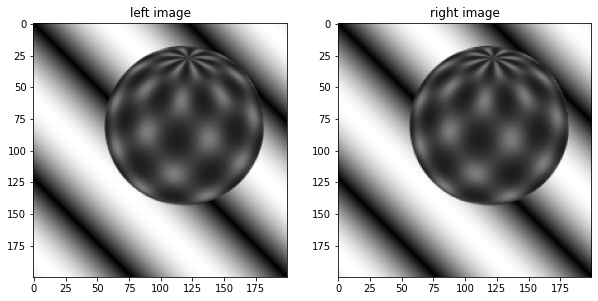

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 10))
ax[0].imshow(np.array(input[0].squeeze()), cmap='gray')
ax[1].imshow(np.array(input[1].squeeze()), cmap='gray')
ax[0].set_title('left image')
ax[1].set_title('right image')

In [ ]:
def make_pyramid(input, level = 3):
    pyramid = []
    pyramid.append(input)
    for lvl in range(level):
        image_rescaled = []
        for im in pyramid[lvl]:
            image_rescaled.append(tf.ToTensor()(rescale(np.array(im.squeeze()), 0.5, anti_aliasing=False)).unsqueeze(0))
        pyramid.append(image_rescaled)
    return pyramid
    
pyramid = make_pyramid(input, level = 3)

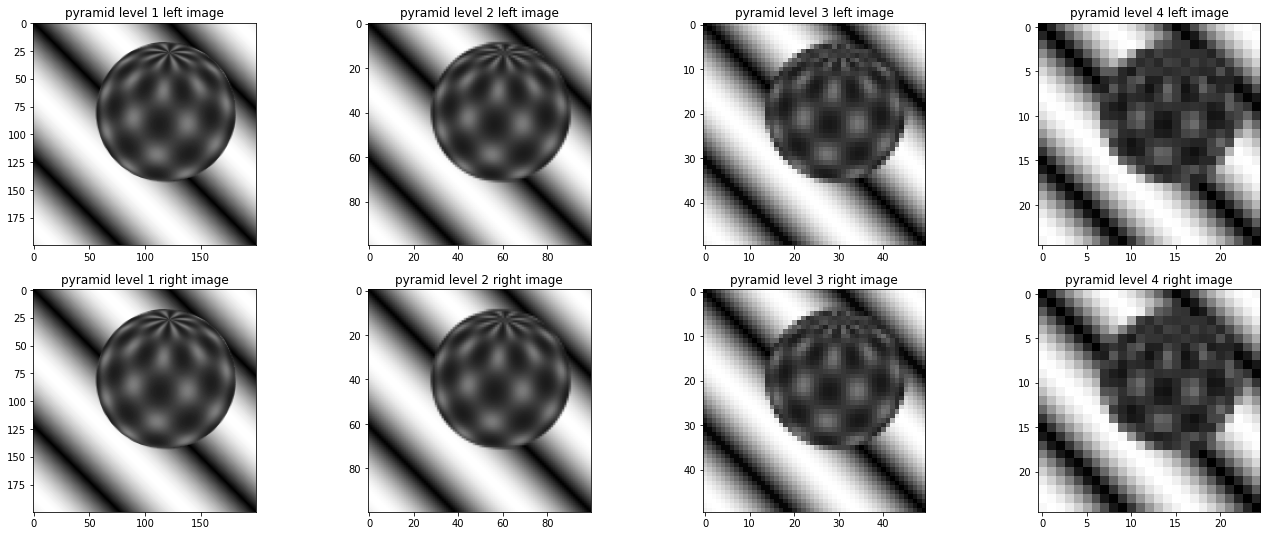

In [ ]:
fig, ax = plt.subplots(2,len(pyramid), figsize=(23, 9))
for i in range(len(pyramid)):
    ax[0,i].imshow(np.array(pyramid[i][0].squeeze()), cmap='gray')
    ax[1,i].imshow(np.array(pyramid[i][0].squeeze()), cmap='gray')
    ax[0,i].set_title(f'pyramid level {i+1} left image')
    ax[1,i].set_title(f'pyramid level {i+1} right image')

In [ ]:
def get_gradient(img, window = (3,3), sigma = 1):
    # g = spatial_gradient(img)  # 1x3x2x4x4
    # dx = g[:,:,0,:,:]
    # dy = g[:,:,1,:,:]

    img = gaussian_blur2d(img, window, (sigma, sigma))

    kernel = 1/12 * torch.tensor([-1, 8, 0 ,-8, 1]).unsqueeze(0)
    kernel_x = kernel.unsqueeze(0)
    kernel_y = kernel.T.unsqueeze(0)


    dx = filter2d(img, kernel_x, padding='same')
    dy = filter2d(img, kernel_y, padding='same')

    # dx = gaussian_blur2d(dx, window, (sigma, sigma))
    # dy = gaussian_blur2d(dy, window, (sigma, sigma)) 

    # dxy = gaussian_blur2d(dx * dy, window, (sigma, sigma))

    return dx,dy

def temporal_grad(im1, im2, window = (3, 3), sigma=1):
    I1 = gaussian_blur2d(im1, (3, 3), (sigma, sigma))
    I2 = gaussian_blur2d(im2, (3, 3), (sigma, sigma)) 
    return I1 - I2

In [ ]:
def get_patch_idx(x, y, H, W, window_length = 3):
    step = window_length[0]//2
    x_rng = np.arange(max(0, x - step), min(W-1, x + step + 1))
    y_rng = np.arange(max(0, y - step), min(H-1, y + step + 1))
    # patch = torch.zeros([3,3])
    return x_rng, y_rng


In [ ]:
def get_optical_flow(dx,dy,dt,window_len = 3, threshold = 2e-7):
    H = dx.shape[-2]
    W = dx.shape[-1]
    mask = np.zeros([H,W])
    u = np.zeros([H,W])
    v = np.zeros([H,W])
    yo = np.zeros([H,W,2])

    for i in range(W):
        for j in range(H):
            
            ix, iy = get_patch_idx(i, j, H, W, window_length = window_len)
            indices = [[l,r] for r in ix for l in iy]   
            A = np.zeros([len(indices),2]) 
            b = np.zeros([len(indices),1])     
            for p in range(len(indices)):
                A[p,0] = dx[indices[p][0],indices[p][1]]
                A[p,1] = dy[indices[p][0],indices[p][1]]
                b[p] = -dt[:,:,indices[p][0],indices[p][1]]
                
            M = A.T @ A
            w, _ = np.linalg.eig(M)
            yo[j,i,:] = w 
            if w[1] >= threshold and w[0] <= 2 * w[1]:
                mask[j,i] = 1
                sol = np.linalg.lstsq(A, b, rcond=None)[0]
                u[j,i] = sol[0]
                v[j,i] = sol[1]

    return v, u, mask

In [ ]:
def get_flow(im1,im2, wnd_len, sigma, th):
    dx, dy = get_gradient(im1, window=wnd_len, sigma = sigma)
    dx = dx.squeeze().squeeze()
    dy = dy.squeeze().squeeze()
    dt = temporal_grad(im1, im2, window=wnd_len, sigma = 0.9*sigma)
    dx = ndimage.median_filter(dx.squeeze(), size=wnd_len[0])
    dy = ndimage.median_filter(dy.squeeze(), size=wnd_len[0])
    v, u, mask = get_optical_flow(dx,dy,dt, window_len = wnd_len, threshold = th)
    return v,u,mask


def MyFlow(input,  window_len, threshold, sigma_v):
    pyramid = make_pyramid(input, level = 3)
    length = len(pyramid) - 1
    window_lengths = [(window_len+k, window_len+k) for k in range(0,len(pyramid)*2, 2)]
    thresholds = [threshold*10**k for k in range(0,length+1)] 
    sigma = [sigma_v**k for k in range(0,length+1)] 
    warped_image = pyramid[length][0]
    rescaled_v = np.zeros(warped_image.shape[-2:])
    rescaled_u = np.zeros(rescaled_v.shape)
    w1 = 1.75
    w2 = 0.25

    for i in tqdm.tqdm(range(len(pyramid) - 1, -1, -1)):
        print(f'\ncalculating optical flow for pyramid at level {i+1}')
        # u1,v1, mask1 = get_flow(pyramid[i][0], pyramid[i][1], window_lengths[i], sigma[i], thresholds[i])
        # u,v, mask = get_flow(warped_image, pyramid[i][1], window_lengths[i], sigma[i], thresholds[i])

        # if u2.max() > 0 and u1.max() > 0:
        #     w1 = u2.max()/(u2.max()+u1.max())
        #     w2 = 1 - w1
        
        # u = (w1*u1 + w2*u2)/2
        # v = (w1*v1 + w2*v2)/2
        
        # print(i, pyramid[i][0].shape, u.max(), v.max())

        v, u = optical_flow_tvl1(warped_image.squeeze(), pyramid[i][1].squeeze())

        rescaled_u = 2*rescale(np.array(rescaled_u + u), scale=2, order = 1, anti_aliasing=True)
        rescaled_v = 2*rescale(np.array(rescaled_v + v), scale=2, order = 1, anti_aliasing=True)
        # warp image using optical flow
        nr, nc = rescaled_u.shape
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
        warped_image = tf.ToTensor()(warp(pyramid[i-1][0].squeeze(), np.array([row_coords + 
            rescaled_v, col_coords + rescaled_u]), mode='edge')).unsqueeze(0)
        
        
    return u,v


In [ ]:
u,v = MyFlow(input,  window_len = 3, threshold=1e-8, sigma_v=1.3)

 67%|██████▋   | 2/3 [00:00<00:00, 13.53it/s]


calculating optical flow for pyramid at level 4

calculating optical flow for pyramid at level 3

calculating optical flow for pyramid at level 2


100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


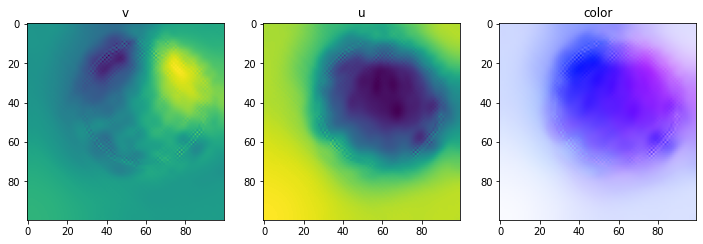

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 10))
ax[0].imshow(np.array(v))
ax[1].imshow(np.array(u))
ax[2].imshow(flowToColor(np.concatenate([v[...,np.newaxis], u[...,np.newaxis]], axis=2)))

ax[0].set_title('v')
ax[1].set_title('u')
ax[2].set_title('color')
plt.show()

In [ ]:
u,v,mask = MyFlow(input,  window_len = 3, threshold=1e-8, sigma_v=1.3)

  0%|          | 0/4 [00:00<?, ?it/s]


calculating optical flow for pyramid at level 4


 25%|██▌       | 1/4 [00:02<00:06,  2.17s/it]

3 torch.Size([1, 1, 25, 25]) 0.0 0.0

calculating optical flow for pyramid at level 3


 50%|█████     | 2/4 [00:09<00:10,  5.27s/it]

2 torch.Size([1, 1, 50, 50]) 0.5764582934696958 0.6643704743256418

calculating optical flow for pyramid at level 2


 75%|███████▌  | 3/4 [00:25<00:10, 10.32s/it]

1 torch.Size([1, 1, 100, 100]) 0.6129951713957774 0.8643258724593077

calculating optical flow for pyramid at level 1


100%|██████████| 4/4 [00:56<00:00, 14.21s/it]

0 torch.Size([1, 1, 200, 200]) 1.6573796065248878 1.6579805906834124


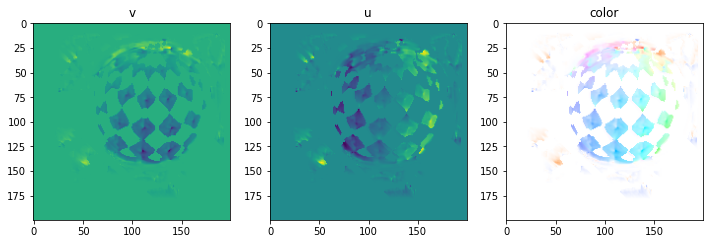

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 10))
ax[0].imshow(np.array(v))
ax[1].imshow(np.array(u))
ax[2].imshow(flowToColor(np.concatenate([v[...,np.newaxis], u[...,np.newaxis]], axis=2)))

ax[0].set_title('v')
ax[1].set_title('u')
ax[2].set_title('color')
plt.show()

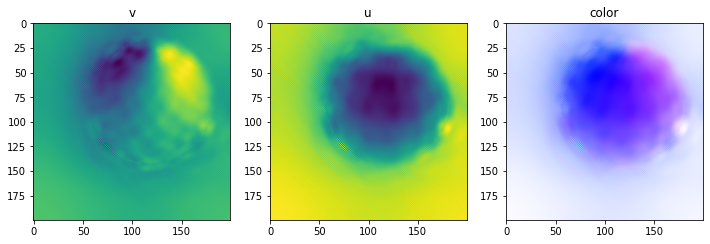

In [ ]:
vv, uu = optical_flow_tvl1(pyramid[0][0].squeeze(), pyramid[0][1].squeeze())
fig, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(vv)
ax[1].imshow(uu)
ax[2].imshow(flowToColor(np.concatenate([vv[...,np.newaxis], uu[...,np.newaxis]], axis=2)))

ax[0].set_title('v')
ax[1].set_title('u')
ax[2].set_title('color')
plt.show()

corridor

In [ ]:
img_dir='Sequences/corridor/'

allscenes = glob.glob(img_dir + '/*png')

input = []
for i in range(len(allscenes)):
    dir_i = allscenes[i]
    # scene = dir_i.split('/')[-1]
    filtered_img = read_image(img_dir=dir_i)
    input.append(filtered_img)

In [ ]:
u,v,mask = MyFlow(input,  window_len = 7, threshold=1e-7, sigma_v=5)

  0%|          | 0/4 [00:00<?, ?it/s]


calculating optical flow for pyramid at level 4


 25%|██▌       | 1/4 [00:07<00:21,  7.19s/it]

3 torch.Size([1, 1, 32, 32]) 0.0 0.0

calculating optical flow for pyramid at level 3


 50%|█████     | 2/4 [00:29<00:31, 15.82s/it]

2 torch.Size([1, 1, 64, 64]) 4.814141069915511 4.685902875631461

calculating optical flow for pyramid at level 2


 75%|███████▌  | 3/4 [01:38<00:40, 40.10s/it]

1 torch.Size([1, 1, 128, 128]) 3.513106139825134 26.37689773393977

calculating optical flow for pyramid at level 1


100%|██████████| 4/4 [04:36<00:00, 69.16s/it]

0 torch.Size([1, 1, 256, 256]) 22.21412852601132 166.64964183866022


In [ ]:
u,v = MyFlow(input,  window_len = 3, threshold=1e-8, sigma_v=1.3)

 75%|███████▌  | 3/4 [00:00<00:00, 20.53it/s]


calculating optical flow for pyramid at level 4

calculating optical flow for pyramid at level 3

calculating optical flow for pyramid at level 2

calculating optical flow for pyramid at level 1


100%|██████████| 4/4 [00:00<00:00,  8.51it/s]


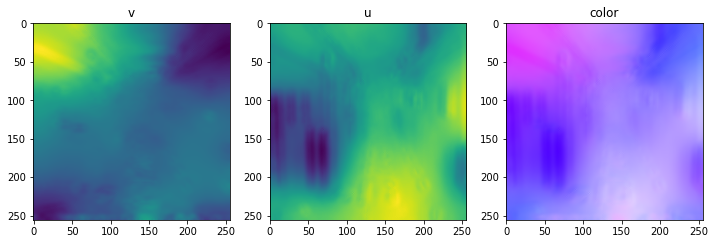

In [ ]:
vv, uu = optical_flow_tvl1(input[0].squeeze(), input[1].squeeze())
fig, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(vv)
ax[1].imshow(uu)
ax[2].imshow(flowToColor(np.concatenate([vv[...,np.newaxis], uu[...,np.newaxis]], axis=2)))

ax[0].set_title('v')
ax[1].set_title('u')
ax[2].set_title('color')
plt.show()

Synth

In [ ]:
img_dir='Sequences/synth/'

allscenes = glob.glob(img_dir + '/*png')

input = []
for i in range(len(allscenes)):
    dir_i = allscenes[i]
    filtered_img = read_image(img_dir=dir_i)
    input.append(filtered_img)

In [ ]:
u,v = MyFlow(input,  window_len = 5, threshold=1e-7, sigma_v=1.3)

 75%|███████▌  | 3/4 [00:00<00:00, 23.30it/s]


calculating optical flow for pyramid at level 4

calculating optical flow for pyramid at level 3

calculating optical flow for pyramid at level 2

calculating optical flow for pyramid at level 1


100%|██████████| 4/4 [00:00<00:00, 13.11it/s]


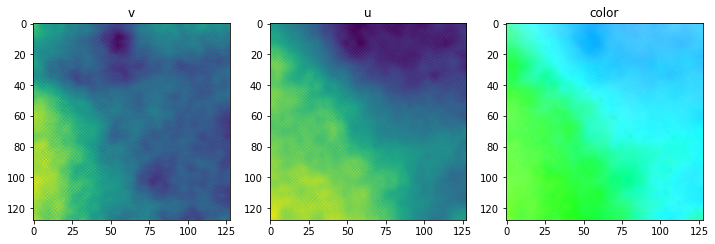

In [ ]:
vv, uu = optical_flow_tvl1(input[0].squeeze(), input[1].squeeze())
fig, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(vv)
ax[1].imshow(uu)
ax[2].imshow(flowToColor(np.concatenate([vv[...,np.newaxis], uu[...,np.newaxis]], axis=2)))

ax[0].set_title('v')
ax[1].set_title('u')
ax[2].set_title('color')
plt.show()

## PART 2

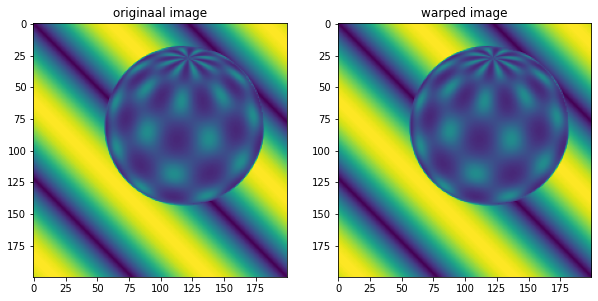

In [ ]:
pyramid = make_pyramid(input, level = 3)

def myWarp(pyramid):
    plt.ion()
    fig, ax = plt.subplots(1,2, figsize=(10, 8))
    ax[0].set_title('originaal image')
    ax[1].set_title('warped image')

    for i in range(len(pyramid)):
        fig.canvas.flush_events()
        # time.sleep(2)
        vv, uu = optical_flow_tvl1(pyramid[i][0].squeeze(), pyramid[i][1].squeeze())
        nr, nc = uu.shape
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
        warped_image = tf.ToTensor()(warp(pyramid[i][1].squeeze(), np.array([row_coords + 
            vv, col_coords + uu]), mode='edge')).squeeze()

        ax[0].imshow(pyramid[i][0].squeeze())
        ax[1].imshow(warped_image)
        fig.canvas.draw()
        plt.pause(2)
    

       


## PART 3

In [ ]:
from scipy import interpolate

%cd '/content/drive/MyDrive/Masters/Vision/A4/'

/content/drive/MyDrive/Masters/Vision/A4


In [ ]:
def read_image(img_dir):
    im = Image.open(img_dir)
    gray = im.convert('L')
    # filtered = gray.filter(ImageFilter.GaussianBlur)
    convert_to_tensor = tf.ToTensor()
    gray = convert_to_tensor(gray).unsqueeze(0)/255
    return gray
   

img_dir='Hotel Sequence/'

allscenes = glob.glob(img_dir + '/*png')

input = []
for i in tqdm.tqdm(range(len(allscenes))):
    dir_i = allscenes[i]
    # scene = dir_i.split('/')[-1]
    filtered_img = read_image(img_dir=dir_i)
    input.append(filtered_img)

100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


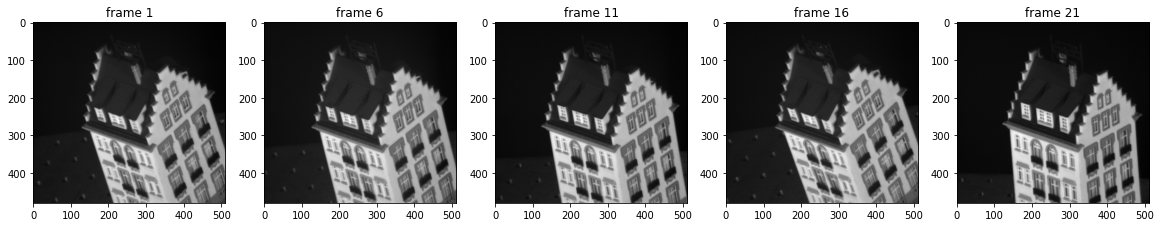

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(np.array(input[5*i].squeeze()), cmap='gray')
    ax[i].set_title(f'frame {5*i+1}')

In [ ]:
def get_gradient(img, window = (3,3), sigma = 1):
    g = spatial_gradient(img)  # 1x3x2x4x4
    dx = g[:,:,0,:,:]
    dy = g[:,:,1,:,:]

    dx = gaussian_blur2d(dx, window, (sigma, sigma))
    dy = gaussian_blur2d(dy, window, (sigma, sigma)) 
    dxy = gaussian_blur2d(dx * dy, window, (sigma, sigma))

    return dx, dy, dxy

def temporal_grad(im1, im2, window = (3, 3), sigma=1):
    I1 = gaussian_blur2d(im1, (3, 3), (sigma, sigma))
    I2 = gaussian_blur2d(im2, (3, 3), (sigma, sigma)) 
    return I1 - I2

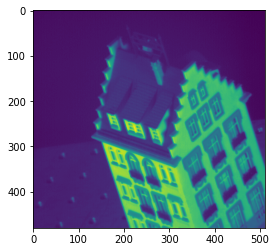

In [ ]:
I = input[0]
plt.imshow(I.squeeze())

In [ ]:
def get_harris(I):
    k = 0.04

    dx, dy, dxy = get_gradient(I)

    dx2 = dx**2
    dy2 = dy**2
    det_m = dx2 * dy2 - dxy**2
    trace_m = dx2 + dy2
        
    scores = det_m - k*trace_m**2
    scores *= (scores>0)
    return np.array(scores.squeeze())

In [ ]:
def get_patch_idx(x, y, H, W, window_length = 3):
    step = window_length[0]//2
    x_rng = np.arange(max(0, x - step), min(W-1, x + step + 1))
    y_rng = np.arange(max(0, y - step), min(H-1, y + step + 1))
    return x_rng, y_rng


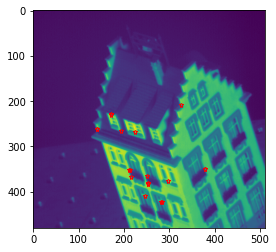

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


In [ ]:
H,W = input[0].shape[-2:]
alpha = 50
tracked = []

s = get_harris(input[0])
indices = np.where(s>5e-16)
indices = np.array([indices[0], indices[1]])

sample_size = 20
rand_indx = np.random.choice(np.arange(indices.shape[1]), sample_size)
initial_points = np.array([[indices[:,idx][0], indices[:,idx][1]] for idx in rand_indx]).astype(int)

plt.imshow(input[0].squeeze())
for i in range(sample_size):
    plt.plot(initial_points[i][1], initial_points[i][0], '*', mfc='none', color='red', markersize=5)
plt.show()

tracked.append(initial_points)
selected_points = initial_points.copy()

for frame in tqdm.tqdm(range(len(input)-1)):
    v, u = optical_flow_tvl1(input[frame+1].squeeze(), input[frame].squeeze())
    new_points = np.zeros(initial_points.shape)

    for i in range(len(rand_indx)):
        new_points[i,0] = min(H-1, selected_points[i][0] + np.round(alpha * v[selected_points[i][0], selected_points[i][1]]).astype(int))
        new_points[i,1] = min(W-1, selected_points[i][1] + np.round(alpha * u[selected_points[i][0], selected_points[i][1]]).astype(int))
        selected_points[i,:] = new_points[i,:]
        
        
    tracked.append(new_points)
    


In [ ]:
def get_lines(tracked, sample_size):
    p = []
    for point in range(sample_size):
        p1 = []
        for i in range(len(tracked)):
            p1.append(tracked[i][point])
        p.append(p1)
    p = np.asarray(p)

    lines = []
    for point in range(sample_size):
        p1 = p[point]
        z = np.polyfit(p1[:,0], p1[:,1], 2)
        f = np.poly1d(z)
        # x_new = np.random.choice(p1[:,0], 20)
        x_new = np.linspace(min(p1[:,0]), max(p1[:,0]), 20)
        y_new = f(x_new)
        lines.append(np.array([y_new, x_new]))
    
    return lines

lines = get_lines(tracked, sample_size)

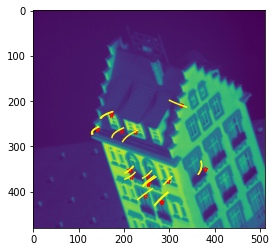

In [ ]:
plt.imshow(input[0].squeeze())

for i in range(sample_size):
    plt.plot(initial_points[i][1], initial_points[i][0], '*', mfc='none', color='red', markersize=5)
    x,y = lines[i]
    plt.plot(x,y, color='yellow')

plt.show()